# SHAP Analysis for CNN

Required
libraries:
- torch
- shap
- matplotlib
- scikit-learn
- pandas
- numpy


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import shap
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Parameters

In [195]:
# Change this to the path where you have extracted the data
DATA_PATH = "../data/human+activity+recognition+using+smartphones/UCI HAR Dataset"
PLOT_PATH = "../plots"


SEQ_LENGTH = 64
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_SHAP_SAMPLES = 1000
RNG = np.random.default_rng(42)

## Load Data

Download the data from the UCI Machine Learning [Repository](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones), and extract the files.

In [46]:
x_train = np.loadtxt(f"{DATA_PATH}/train/X_train.txt")
y_train = np.loadtxt(f"{DATA_PATH}/train/y_train.txt")
x_test = np.loadtxt(f"{DATA_PATH}/test/X_test.txt")
y_test = np.loadtxt(f"{DATA_PATH}/test/y_test.txt")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (7352, 561), y_train: (7352,)
x_test: (2947, 561), y_test: (2947,)


In [47]:
features = np.loadtxt(f"{DATA_PATH}/features.txt", dtype=str)
features = features[:, 1]
print("Shape of features: ", features.shape)

Shape of features:  (561,)


In [48]:
x_train = pd.DataFrame(x_train, columns=features, dtype=np.float32)
x_test = pd.DataFrame(x_test, columns=features, dtype=np.float32)
x_train.shape, x_test.shape

((7352, 561), (2947, 561))

In [49]:
y_train = pd.DataFrame(y_train, columns=["label"], dtype=np.int32)
y_test = pd.DataFrame(y_test, columns=["label"], dtype=np.int32)
y_train.shape, y_test.shape

((7352, 1), (2947, 1))

In [50]:
NUM_CLASSES = len(np.unique(y_train))
y_train.value_counts()

label
6        1407
5        1374
4        1286
1        1226
2        1073
3         986
Name: count, dtype: int64

In [51]:
x_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


## Preprocess

### Zero index the labels

In [52]:
y_train = y_train["label"].apply(lambda x: x - 1)
y_test = y_test["label"].apply(lambda x: x - 1)
y_train.value_counts()

label
5    1407
4    1374
3    1286
0    1226
1    1073
2     986
Name: count, dtype: int64

### Scale data

In [53]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [54]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.values).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test.values).float()

### Create sliding window sequences

In [55]:
def create_sequences(
    data: torch.Tensor, targets: torch.Tensor, seq_length: int = SEQ_LENGTH
):
    sequences = []
    targets_seq = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        targets_seq.append(targets[i + seq_length])
    x_seq, y_seq = torch.stack(sequences), torch.stack(targets_seq)
    return x_seq.permute(0, 2, 1), y_seq


x_train_seq, y_train_seq = create_sequences(x_train, y_train, seq_length=SEQ_LENGTH)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, seq_length=SEQ_LENGTH)

In [59]:
from pprint import pprint

pprint(
    {
        "x_train_seq": x_train_seq.shape,
        "y_train_seq": y_train_seq.shape,
        "x_test_seq": x_test_seq.shape,
        "y_test_seq": y_test_seq.shape,
    },
    indent=2,
)

{ 'x_test_seq': torch.Size([2883, 561, 64]),
  'x_train_seq': torch.Size([7288, 561, 64]),
  'y_test_seq': torch.Size([2883]),
  'y_train_seq': torch.Size([7288])}


## Model Definition

In [104]:
class CNNClassifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int = 6):
        super(CNNClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_dim, 32, kernel_size=3, stride=2, padding=1),
            nn.Tanh(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.Tanh(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [111]:
model = CNNClassifier(input_dim=x_train_seq.shape[1], num_classes=NUM_CLASSES)

## Training

### Create data loaders

In [112]:
train_ds = TensorDataset(x_train_seq, y_train_seq.long().squeeze())
test_ds = TensorDataset(x_test_seq, y_test_seq.long().squeeze())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

### Define loss function

In [113]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Train model

In [114]:
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    if epoch % 2 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}], Loss: {avg_loss:.5f}")

Epoch [0/50], Loss: 0.56563
Epoch [2/50], Loss: 0.32390
Epoch [4/50], Loss: 0.25719
Epoch [6/50], Loss: 0.20879
Epoch [8/50], Loss: 0.17390
Epoch [10/50], Loss: 0.16339
Epoch [12/50], Loss: 0.13955
Epoch [14/50], Loss: 0.13667
Epoch [16/50], Loss: 0.11476
Epoch [18/50], Loss: 0.10730
Epoch [20/50], Loss: 0.12238
Epoch [22/50], Loss: 0.10957
Epoch [24/50], Loss: 0.11315
Epoch [26/50], Loss: 0.09124
Epoch [28/50], Loss: 0.09274
Epoch [30/50], Loss: 0.07581
Epoch [32/50], Loss: 0.06325
Epoch [34/50], Loss: 0.09459
Epoch [36/50], Loss: 0.07064
Epoch [38/50], Loss: 0.07743
Epoch [40/50], Loss: 0.04820
Epoch [42/50], Loss: 0.05792
Epoch [44/50], Loss: 0.04845
Epoch [46/50], Loss: 0.03289
Epoch [48/50], Loss: 0.06304


## Evaluate

In [115]:
with torch.no_grad():
    outputs = model(x_test_seq)
    probabilities = torch.softmax(outputs, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    # accuracy = ((predicted + 1) == y_test_seq.long().squeeze()).float().mean()
    accuracy = (predictions == y_test_seq.long().squeeze()).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")

Test Accuracy: 0.9084


In [116]:
print(
    classification_report(
        y_test_seq.long().squeeze().numpy(),
        predictions.numpy(),
        target_names=[
            "Walking",
            "Walking Upstairs",
            "Walking Downstairs",
            "Sitting",
            "Standing",
            "Laying",
        ],
    )
)

                    precision    recall  f1-score   support

           Walking       0.96      0.94      0.95       496
  Walking Upstairs       0.94      0.93      0.93       471
Walking Downstairs       0.92      0.88      0.90       420
           Sitting       0.86      0.83      0.85       467
          Standing       0.83      0.92      0.87       501
            Laying       0.95      0.94      0.94       528

          accuracy                           0.91      2883
         macro avg       0.91      0.91      0.91      2883
      weighted avg       0.91      0.91      0.91      2883



In [129]:
torch.save(model.state_dict(), "../plots/cnn_model.pth")

## SHAP Calculations

### Create background dataset

In [119]:
def create_balanced_background(
    x_data: torch.Tensor, y_data: torch.Tensor, n_per_class: int = 20
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Create a balanced background dataset with equal representation from each class.

    Parameters:
    -----------
    x_data : torch.Tensor
        Input features
    y_data : torch.Tensor
        Target labels
    n_per_class : int
        Number of samples to include per class

    Returns:
    --------
    torch.Tensor
        Balanced background dataset
    """
    y_np = y_data.detach().cpu().numpy()
    balanced_indices = []

    for cls in np.arange(NUM_CLASSES):
        cls_indices = np.where(y_np == cls)[0]
        if len(cls_indices) >= n_per_class:
            # If we have enough samples, randomly select n_per_class
            selected_indices = RNG.choice(cls_indices, n_per_class, replace=False)
            # selected_indices = np.random.choice(cls_indices, n_per_class, replace=False)
        else:
            # If not enough samples, use all available with replacement
            selected_indices = RNG.choice(cls_indices, n_per_class, replace=True)
            print(
                f"Warning: Class {cls} has only {len(cls_indices)} samples, using with replacement"
            )
        balanced_indices.extend(selected_indices)

    np.random.shuffle(balanced_indices)
    return x_data[balanced_indices], y_data[balanced_indices]


background_data, background_labels = create_balanced_background(
    x_train_seq, y_train_seq, n_per_class=20
)

### Calculate SHAP

In [120]:
def calculate_shap_values(
    nn_model: nn.Module,
    background: torch.Tensor,
    test_data: torch.Tensor,
    max_samples: int = 500,
) -> tuple[shap.DeepExplainer, np.ndarray, torch.Tensor]:
    """
    Calculate SHAP values for a CNN model.

    Parameters:
    -----------
    nn_model : torch.nn.Module
        The trained CNN model
    background : torch.Tensor
        Background data for the SHAP explainer (subset of training data)
    test_data : torch.Tensor
        Test data to explain
    max_samples : int
        Maximum number of test samples to explain

    Returns:
    --------
    tuple
        (explainer, shap_values, test_subset)
    """
    nn_model.eval()
    # Limit the number of samples to analyze to avoid memory issues
    test_samples = (
        test_data[:max_samples] if len(test_data) > max_samples else test_data
    )

    print(f"Using {len(background_data)} background samples...")
    expl = shap.DeepExplainer(model, background)

    explanations = expl.shap_values(test_samples)
    print(f"SHAP values shape: {explanations.shape} for {len(test_samples)} samples")

    return expl, explanations, test_samples


# Calculate SHAP values
explainer, shap_values, test_subset = calculate_shap_values(
    model,
    background_data,
    x_test_seq,
    max_samples=NUM_SHAP_SAMPLES,
)

Using 120 background samples...
SHAP values shape: (1000, 561, 64, 6) for 1000 samples


In [126]:
# Save the shap values if needed
np.savez("../plots/shap_values_cnn.npz", shap_values=shap_values)

### Aggregate SHAP
Since we are dealing with a sequence model, we need to aggregate the SHAP values across the sequence length.
There are a number of ways to do this. We shall look at the SHAP values for the last time step.

In [121]:
shap_t = shap_values[:, :, -1, :]
print("Shap shape after averaging sequence:", shap_t.shape)

Shap shape after averaging sequence: (1000, 561, 6)


## SHAP Visualizations

In [122]:
shap.initjs()

In [123]:
CLASS_NAMES = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Laying",
]

### Global

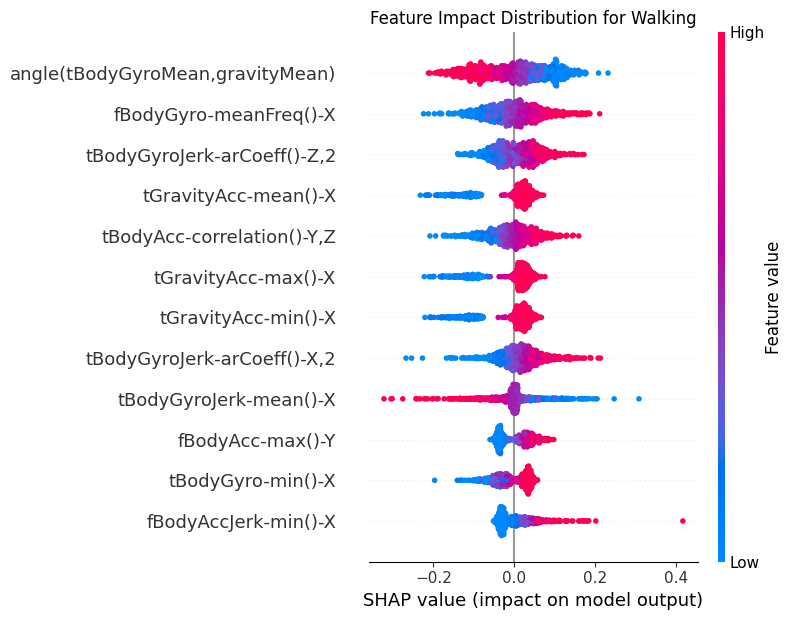

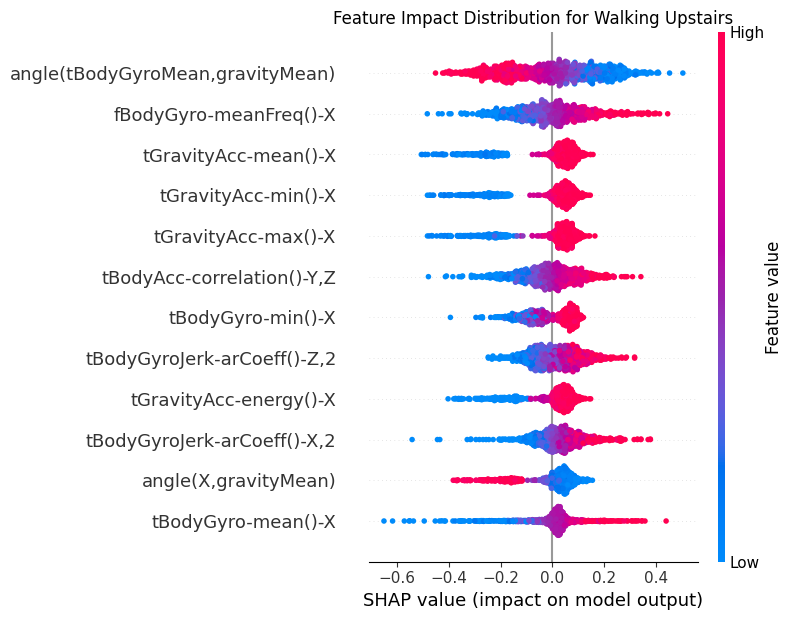

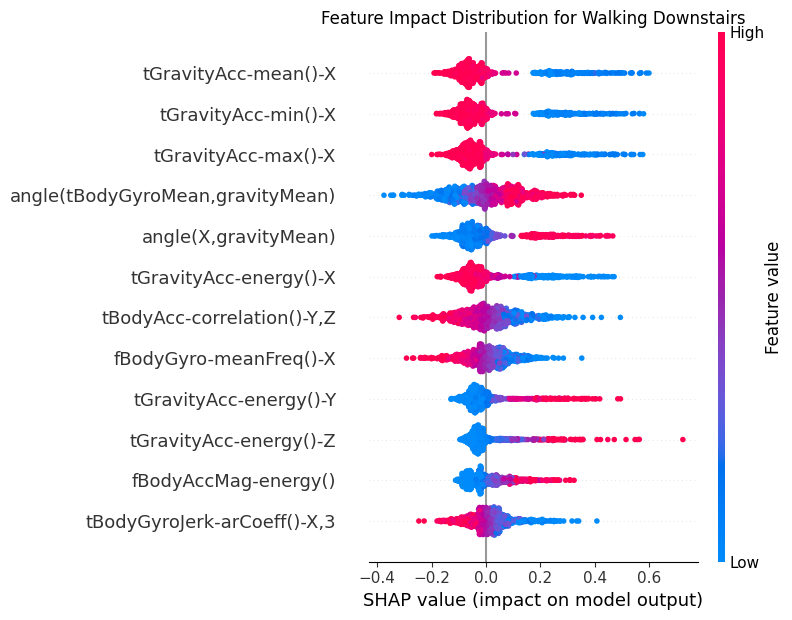

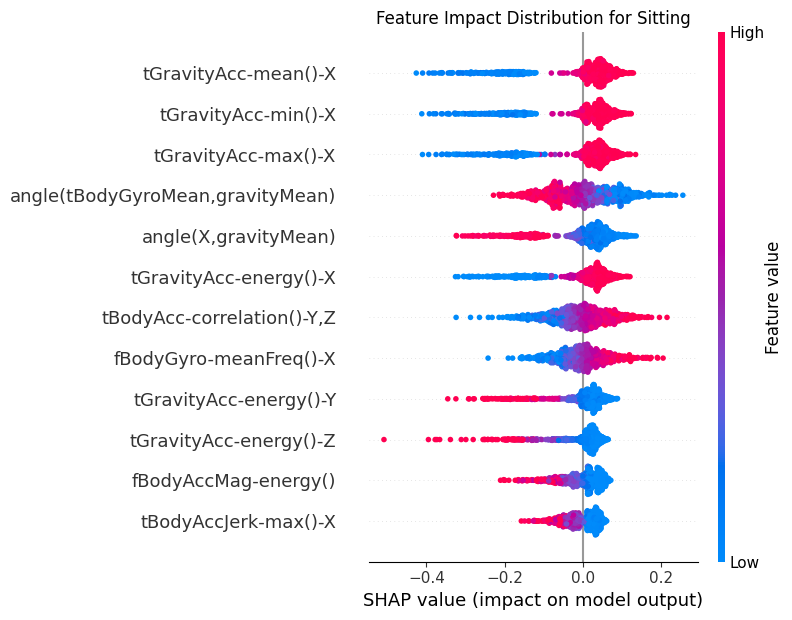

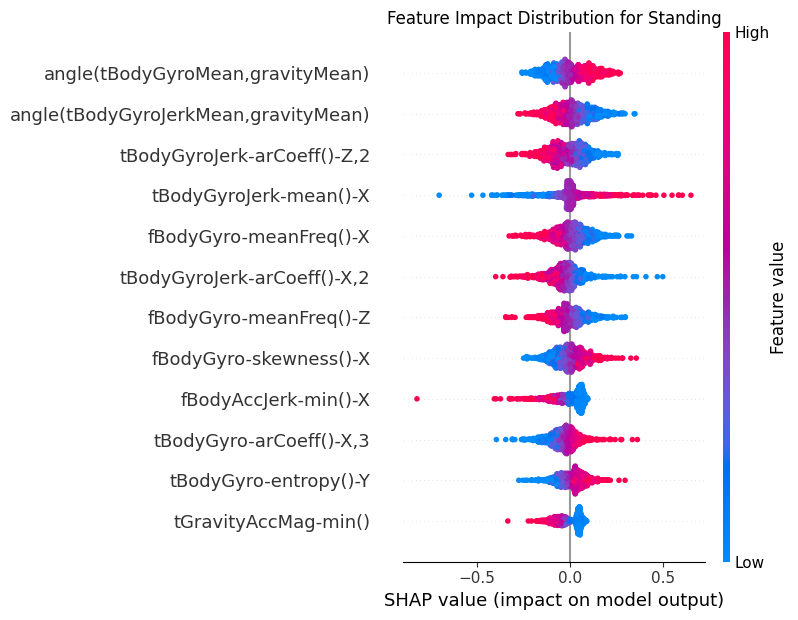

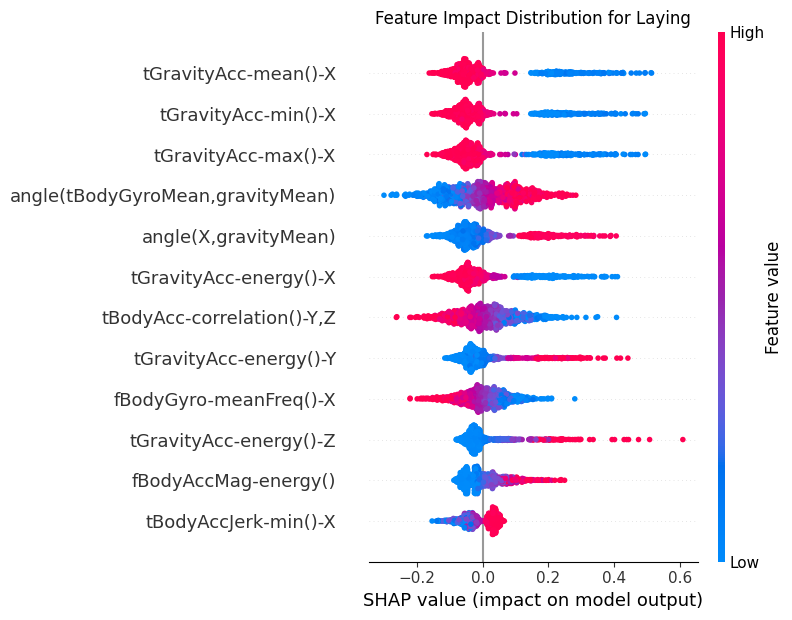

In [127]:
for class_idx in range(shap_t.shape[2]):
    class_name = CLASS_NAMES[class_idx]

    # Extract SHAP values for this class
    class_shap = shap_t[:, :, class_idx]

    # Create SHAP Explanation object
    shap_explanation = shap.Explanation(
        values=class_shap,
        base_values=np.zeros(class_shap.shape[0]),
        data=test_subset[:, :, -1].detach().cpu().numpy(),
        feature_names=features.tolist(),
    )

    # Create beeswarm plot
    plt.figure(figsize=(10, 8))
    shap.plots.beeswarm(
        shap_explanation,
        max_display=12,  # Show top 20 features
        show=False,
        order=shap.Explanation.abs.mean(0),  # Order by mean absolute SHAP value
        group_remaining_features=False,
        log_scale=False,
    )
    plt.title(f"Feature Impact Distribution for {class_name}")
    plt.tight_layout()
    _class_name = class_name.replace(" ", "_")
    plt.savefig(f"{PLOT_PATH}/beeswarm_{_class_name}_cnn.png")

### Dependency

In [229]:
top_n = 1

for class_idx, class_name in enumerate(CLASS_NAMES):
    top_feature_indices = np.argsort(-np.mean(np.abs(shap_t[:, :, class_idx]), axis=0))[
        :top_n
    ]

    fig, axes = plt.subplots(top_n, 1, figsize=(10, 3 * top_n))

    # For each top feature, create subplot
    for idx, feature_idx in enumerate(top_feature_indices):
        if top_n == 1:
            ax = axes
        else:
            ax = axes[idx]

        feature_name = features[feature_idx]
        feature_values = test_subset[:, feature_idx, -1].detach().cpu().numpy()
        shap_values_feature = shap_t[:, feature_idx, class_idx]

        scatter = ax.scatter(
            feature_values,
            shap_values_feature,
            c=feature_values,
            cmap="coolwarm",
            alpha=0.7,
            s=50,
        )

        ax.axhline(y=0, color="gray", linestyle="--")
        ax.set_xlabel(f"Feature Value: {feature_name}")
        ax.set_ylabel("SHAP Value")
        ax.grid(True)
        ax.set_title(f"Feature: {feature_name} - Class: {class_name}")

        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label("Feature Value")

    plt.tight_layout()
    _class_name = class_name.replace(" ", "_")
    plt.savefig(f"{PLOT_PATH}/dep_{_class_name}_cnn.png")

### Local

In [196]:
def sample_by_class(y_data: torch.Tensor, class_index: int, n: int = 1) -> np.ndarray:
    """Get sample indices for each class"""
    y_np = y_data.detach().cpu().numpy()
    class_indices = np.where(y_np == class_index)[0]
    return RNG.choice(class_indices, n, replace=False)

In [221]:
def plot_local_shap(
    shap_val: np.ndarray, x: torch.Tensor, y: torch.Tensor, class_index: int
) -> None:
    """Plot local SHAP values for a given class and sample"""
    x_samples = x[:NUM_SHAP_SAMPLES]
    y_samples = y[:NUM_SHAP_SAMPLES]
    sample_idx = sample_by_class(y_samples, class_index, n=1)[0]
    shap_c = shap_val[:, :, class_index]

    expl = shap.Explanation(
        values=shap_c,
        base_values=np.zeros(shap_c.shape[0]),
        data=x_samples[:, :, -1].detach().cpu().numpy(),
        feature_names=features.tolist(),
    )
    plt.clf()
    shap.plots.bar(expl[sample_idx], max_display=12, show=False)
    cls_name = CLASS_NAMES[class_index].replace(" ", "_")
    plt.title(f"Local SHAP Values for {cls_name}")
    plt.tight_layout()
    plt.savefig(f"{PLOT_PATH}/local_{cls_name}_cnn.png")
    plt.show()

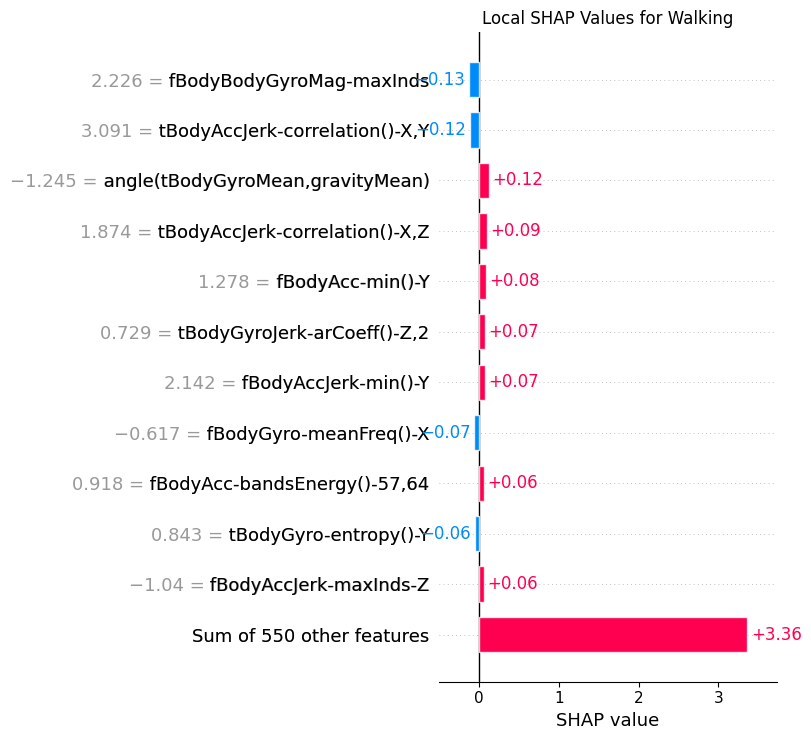

In [222]:
plot_local_shap(shap_t, x_test_seq, y_test_seq, 0)

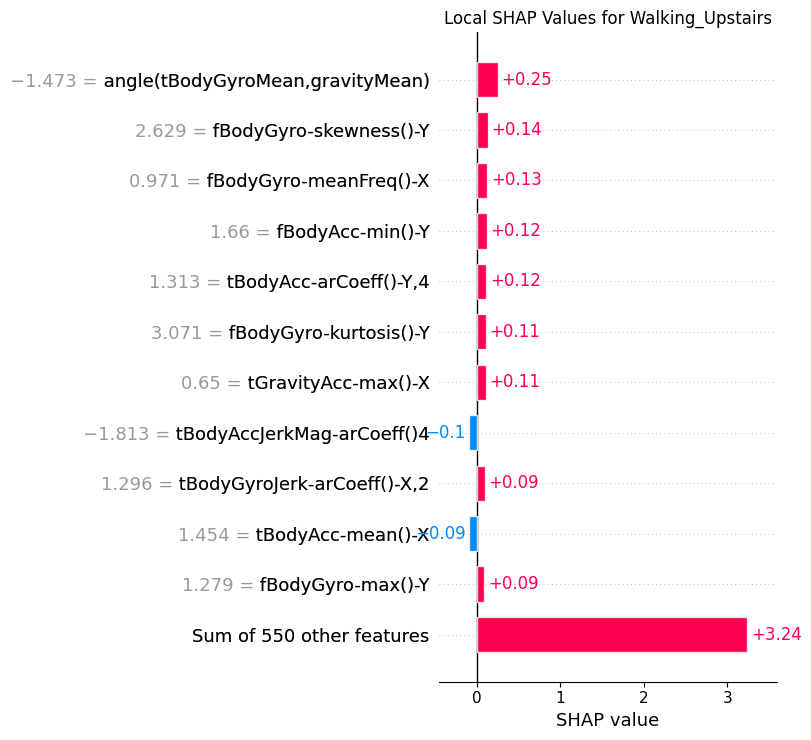

In [223]:
plot_local_shap(shap_t, x_test_seq, y_test_seq, 1)

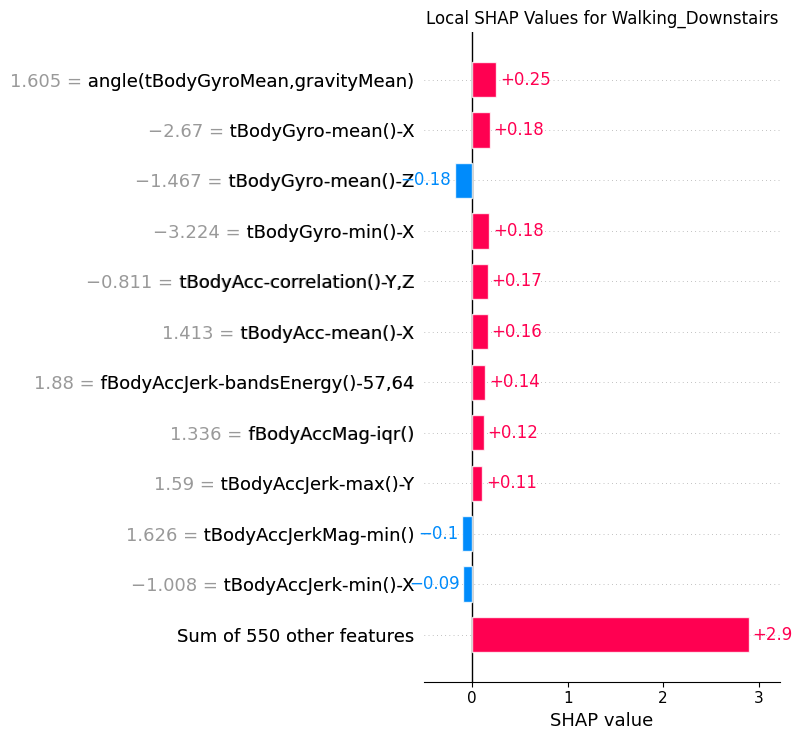

In [224]:
plot_local_shap(shap_t, x_test_seq, y_test_seq, 2)

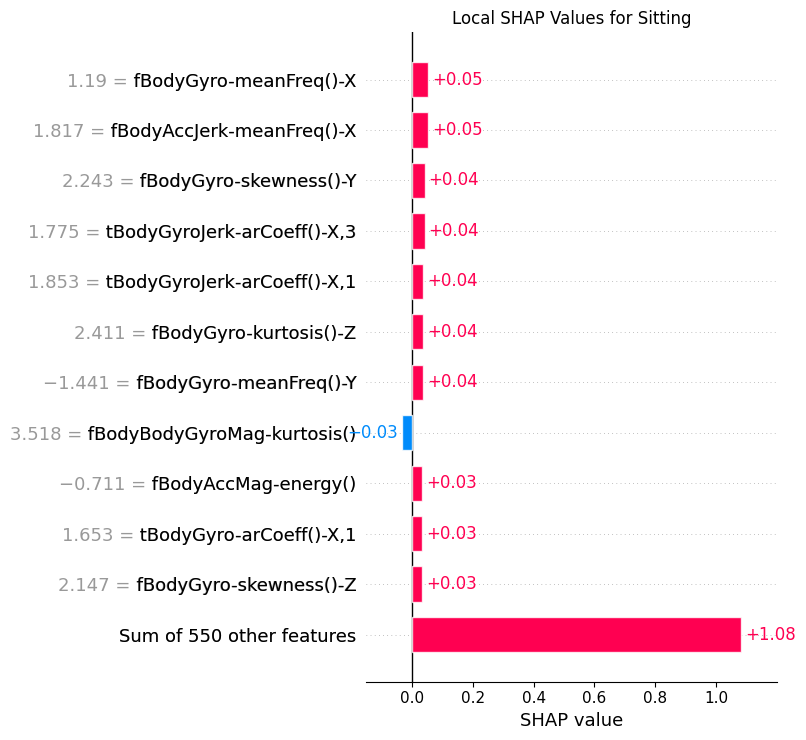

In [225]:
plot_local_shap(shap_t, x_test_seq, y_test_seq, 3)

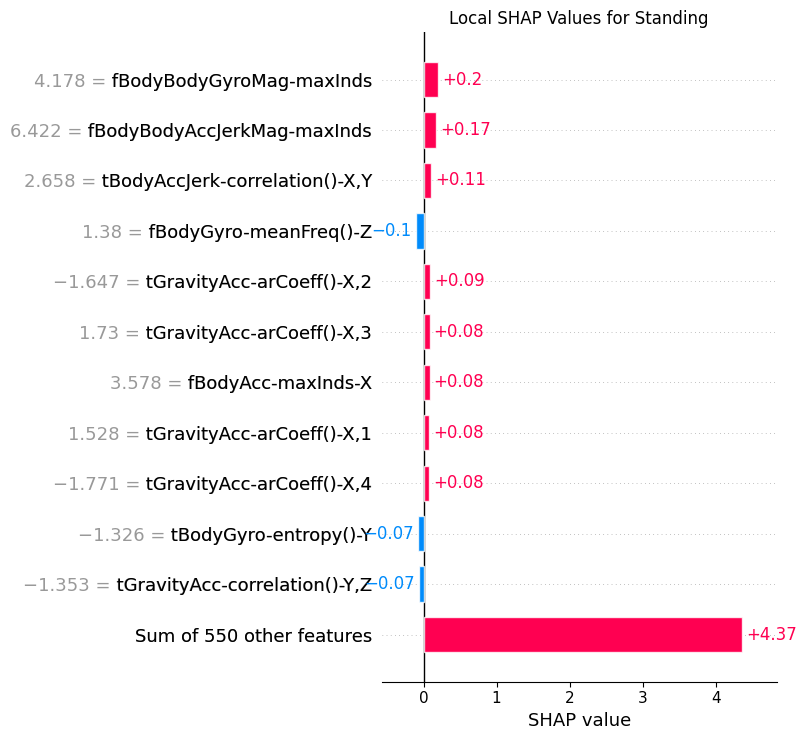

In [226]:
plot_local_shap(shap_t, x_test_seq, y_test_seq, 4)

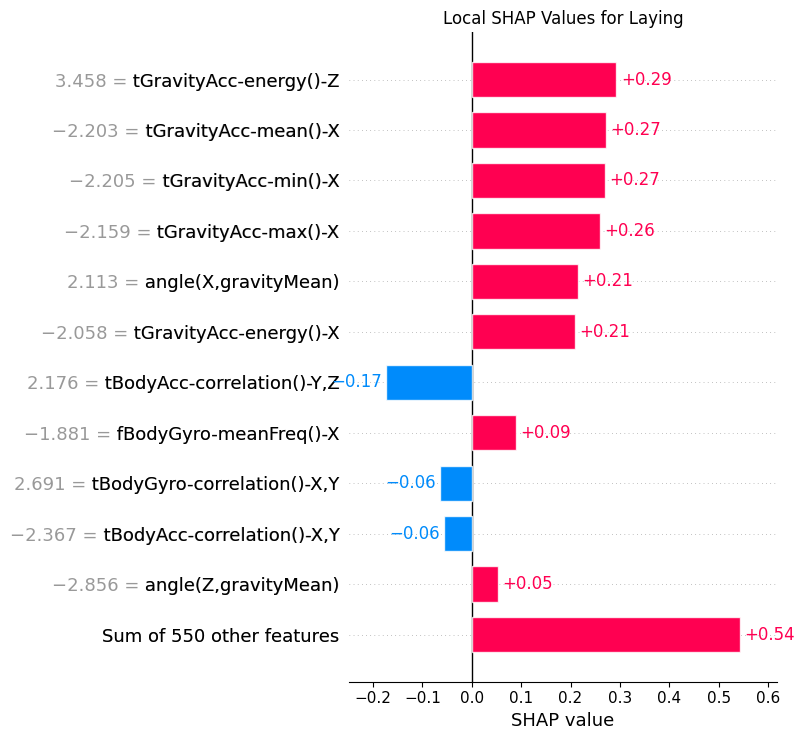

In [227]:
plot_local_shap(shap_t, x_test_seq, y_test_seq, 5)